In [1]:
import os

In [2]:
os.environ["MLFLOW_TRACKING_URI"] = 'http://localhost:8990'
os.environ["MLFLOW_EXPERIMENT_NAME"] = "Prueba_local"
os.environ["GIT_PYTHON_REFRESH"] = "quiet"

In [3]:
os.environ["MLFLOW_TRACKING_URI"]

'http://localhost:8990'

In [4]:
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet

In [5]:
def get_notebook_name():
    """Execute JS code to save Jupyter notebook name to variable notebook_name"""
    from IPython.core.display import Javascript, display_javascript
    js = Javascript("""IPython.notebook.kernel.execute('notebook_name = "' + IPython.notebook.notebook_name + '"');""")
    return display_javascript(js)

def get_notebook_path():
    """Execute JS code to save Jupyter notebook path to variable notebook_path"""
    from IPython.core.display import Javascript, display_javascript
    js = Javascript("""IPython.notebook.kernel.execute('notebook_path = "' + IPython.notebook.notebook_path + '"');""")
    return display_javascript(js)

In [6]:
notebook_path = get_notebook_path()
notebook_name = get_notebook_name()

print(f"{notebook_path}")
print(f"{notebook_name}")

None
None


In [7]:
file = os.getcwd()+ '\\'+ notebook_name
file

'C:\\Users\\arouiller\\DataWeek 2022\\1.MLFlowPrimerosPAsos\\4. MLFlow en tracking server.ipynb'

In [8]:
database_dir = 'c:\\database\\winedata\\'
file_name = 'winequality-red.csv'

In [9]:
data = pd.read_csv(database_dir + file_name, sep = ';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [10]:
# Split the data into training and test sets. (0.75, 0.25) split.
train, test = train_test_split(data)

In [11]:
# The predicted column is "quality" which is a scalar from [3, 9]
train_x = train.drop(["quality"], axis=1)
test_x = test.drop(["quality"], axis=1)
train_y = train[["quality"]]
test_y = test[["quality"]]

In [12]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [13]:
experiment_name = 'Regresion_lineal_clasificacion_vinos'

try:
    exp_id = mlflow.create_experiment(name=experiment_name)
except Exception as e:
    exp_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    
exp_id

'1'

C:\Users\arouiller\Anaconda3\envs\MLFlow\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


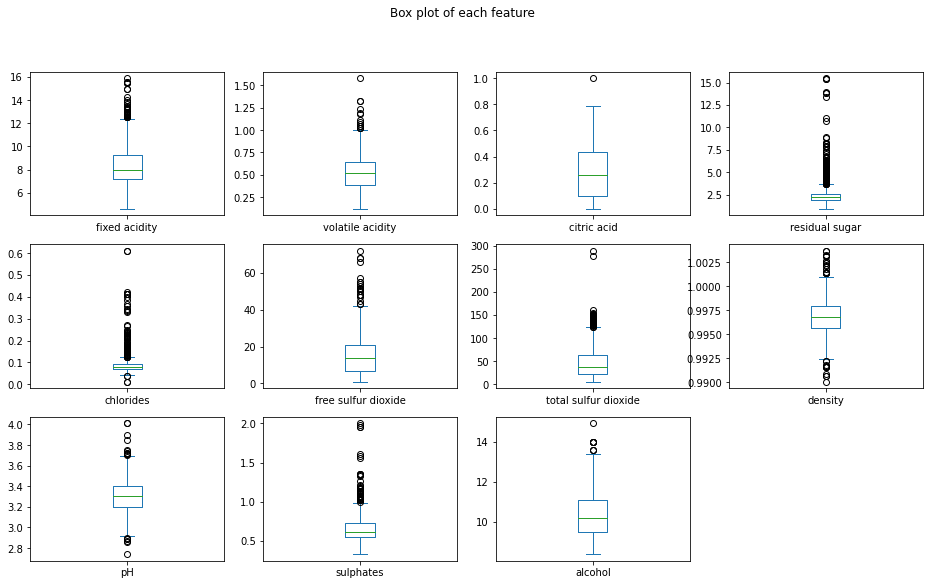

In [15]:
if 'images' not in os.listdir():
    os.mkdir ('images')
    
alpha, l1_ratio = 0.18, 0.0015
    
with mlflow.start_run(experiment_id=exp_id, run_name='RegresionLineal_PruebaLocal_ConTAGS'):
    train_x.plot(kind='box', subplots=True, layout=(3,4), figsize=(16,9), title='Box plot of each feature')
    plt.savefig('images/distribution_plot_all_features.png')
    mlflow.log_artifacts('images')
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    lr.fit(train_x, train_y)
    predicted_qualities = lr.predict(test_x)
    (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)
    
    #mlflow.log_param('alpha', alpha)
    #mlflow.log_param('l1_ratio', l1_ratio)
    mlflow.log_params({'alpha': alpha, 'l1_ratio':l1_ratio})
    
    #mlflow.log_metric('rmse', rmse)
    #mlflow.log_metric('mae', mae)
    mlflow.log_metrics({'rmse': rmse, 'mae':mae, 'r2':r2})
    
    mlflow.log_artifact(file, 'source')
    
    mlflow.set_tags({'ProblemType':'Regresion', 'ModelType':'Elasticnet', 'ModelLibrary':'Scikit-Learn', 'developer':'arouiller'})
    
    mlflow.sklearn.log_model(lr, "PlainRegression_Model")
    
    mlflow.end_run()

In [19]:
alphas = [0.15, 0.015, 0.0015]
l1_ratios = [0.1, 0.01, 0.001]

iteracion = 1

for alpha in alphas:
    for l1_ratio in l1_ratios:    
        with mlflow.start_run(experiment_id=exp_id, run_name='RegresionLineal_PruebaLocal_ConGridSearch_Iteracion:'+str(iteracion)):
            
            iteracion=iteracion+1

            lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
            lr.fit(train_x, train_y)
            predicted_qualities = lr.predict(test_x)
            (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

            #mlflow.log_param('alpha', alpha)
            #mlflow.log_param('l1_ratio', l1_ratio)
            mlflow.log_params({'alpha': alpha, 'l1_ratio':l1_ratio})

            #mlflow.log_metric('rmse', rmse)
            #mlflow.log_metric('mae', mae)
            mlflow.log_metrics({'rmse': rmse, 'mae':mae, 'r2':r2})
            
            mlflow.log_artifact(file, 'source')

            mlflow.set_tags({'ProblemType':'Regresion', 'ModelType':'Elasticnet', 'ModelLibrary':'Scikit-Learn', 'developer':'arouiller'})

            mlflow.sklearn.log_model(lr, "PlainRegression_Model")